# Imports

In [1]:
%%time
#Imports requisite packages
import os
import time
import numpy
import pickle
import cProfile
import itertools
import matplotlib
from sklearn.svm import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from matplotlib import pyplot as plt
from sklearn.cross_validation import *
from sklearn.feature_selection import *
from sklearn.ensemble import IsolationForest

#%jsroot on9
%matplotlib inline
matplotlib.use('Agg')

CPU times: user 1.1 s, sys: 239 ms, total: 1.33 s
Wall time: 2.04 s


/Users/fsiroky/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/fsiroky/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Function Definitions

In [2]:
%%time
#Takes the converted tree and turns it into an
#n-by-30 array usable by sklearn.
def outputs(array):
    #Only uses events with non-zero luminosity
    goodEvents = array[array['lumi'] != 0]
    ind = numpy.lexsort((goodEvents['lumiId'],goodEvents['runId']))
    events = goodEvents[ind]
    dataset = numpy.empty([len(goodEvents),30])
    target = numpy.empty([len(goodEvents)])
    badOnes = numpy.array([])

    #Fills dataset array with proper features
    for j, event in enumerate(events):
        try:
            dataset[j,0:7] = event['qPFJetPt']
            dataset[j,7:14] = event['qPFJetEta']
            dataset[j,14:21] = event['qPFJetPhi']
            dataset[j,21:28] = event['qNVtx']
            dataset[j,28] = event['crossSection']
            dataset[j,29] = event['lumi']
            target[j] = event['isSig']
        except ValueError:
            badOnes = numpy.append(badOnes,j)
            
    #Takes out corrupt events
    mask = numpy.zeros(len(dataset), dtype=bool)
    mask[badOnes.astype(int)] = True
    mask = ~mask
    dataset = dataset[mask]
    target = target[mask]
       
    return dataset, target

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 8.82 µs


In [3]:
#Function that plots confusion matrix, taken from sklearn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.     
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = numpy.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        print("Normalized confusion matrix")
    else:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = numpy.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max()*.7
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Prep

In [4]:
#Loads pickled dataset with MET data
inFile  = open('dataWithMet.pkl', 'rb')
dataset = pickle.load(inFile, encoding = "latin1")
target  = pickle.load(inFile, encoding = "latin1")
inFile.close()

#Loads pickled label data
inFile = open('jetMetTarget.pkl', 'rb')
target = pickle.load(inFile, encoding = "latin1")
inFile.close()

In [5]:
sigInd     = numpy.where(target==1)
backInd    = numpy.where(target==0)
sigVals    = dataset[sigInd]
backVals   = dataset[backInd]
sigTarget  = target[sigInd]
backTarget = target[backInd]

sigTrain, sigTest, sigTrainTarget, sigTestTarget = train_test_split(sigVals, sigTarget, test_size = .5, random_state = 42)

In [6]:
#Scales the data to zero mean and unit variance
#and changes labels from 0 to -1
scaler = StandardScaler()
scaler.fit(sigTrain)

sigTrain = scaler.transform(sigTrain)
sigTest  = scaler.transform(sigTest)
backVals = scaler.transform(backVals)

backTarget[backTarget == 0] = -1

In [7]:
#Runs the classifier with given nuVal and gammaVal
nuVal    = 0.05
gammaVal = 0.06
osvmClf  = OneClassSVM(nu=nuVal, kernel = 'rbf', gamma = gammaVal)
osvmClf.fit(sigTrain)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.06, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [8]:
#Here if you need to pickle classifier
# outFile = open("osvm_nu_%s_gamma_%s.pkl" % (nuVal, gammaVal), 'wb')
# pickle.dump(osvmClf, outFile)
# outFile.close()

In [9]:
# Here if you need to import pickled classifier
# inFile = open("osvm_nu_%s_gamma_%s.pkl" % (nuVal, gammaVal), 'rb')
# osvmClf = pickle.load(inFile, encoding = "latin1")
# inFile.close()

In [10]:
#Runs predictions on classifier for later calculations
y_pred_train = osvmClf.predict(sigTrain)
y_pred_test = osvmClf.predict(sigTest)
y_pred_outliers = osvmClf.predict(backVals)

In [11]:
#Finds numbers of false negatives/positives and true positives
falseNegTrain = y_pred_train[y_pred_train == -1].size
falseNegTest = y_pred_test[y_pred_test == -1].size
falsePos = y_pred_outliers[y_pred_outliers == 1].size
truePosTrain = y_pred_train[y_pred_train == 1].size
truePosTest = y_pred_test[y_pred_test == 1].size

In [12]:
#Plots classification results for signal and background
osvmArrs = []
osvmHists = []

#Separates decision function results into signal and background
#along with training and testing
osvmArrs.append(osvmClf.decision_function(sigTrain).ravel())
osvmArrs.append(osvmClf.decision_function(sigTest).ravel())
osvmArrs.append(osvmClf.decision_function(backVals).ravel())

Loss Rate                                           :  5.10517587501091
Pollution Rate                                      :  0.7313599094245905
Number of errors on training set :  5726  Percentage:  4.997817927904338
Number of errors on test set     :  5849  Percentage:  5.10517587501091
Number of errors on outliers set :  801   Percentage:  24.2874469375379


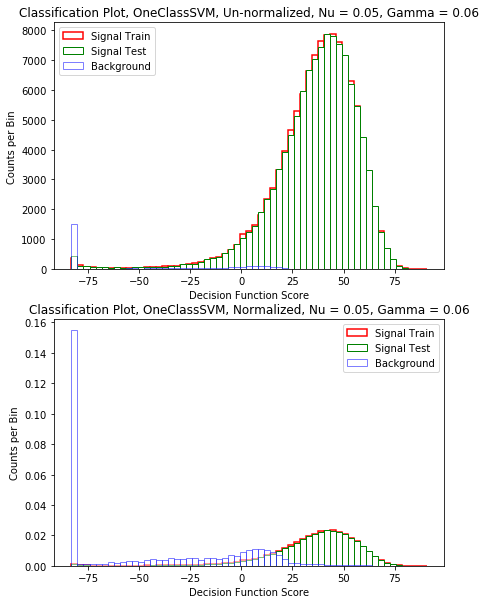

In [13]:
#Sets up plot boundaries
plotMin = min(min(osvmArrs[0]), min(osvmArrs[1]), min(osvmArrs[2]))
plotMax = max(max(osvmArrs[0]), max(osvmArrs[1]), max(osvmArrs[2]))
binz = numpy.linspace(plotMin, plotMax, 60)

#Creates first histogram of Un-normalized Classification
plt.figure(figsize=(7, 10))
plt.subplot(211)
plt.hist(osvmArrs[0], normed = False, bins = binz, edgecolor = 'red',   
         facecolor = 'white', alpha=1, label = "Signal Train", linewidth = 1.5)
plt.hist(osvmArrs[1], normed = False, bins = binz, edgecolor = 'green', 
         facecolor = 'white', alpha=1, label = "Signal Test")
plt.hist(osvmArrs[2], normed = False, bins = binz, edgecolor = 'blue',  
         facecolor = 'white', alpha=.5, label = "Background")
plt.title("Classification Plot, OneClassSVM, Un-normalized, Nu = %s, Gamma = %s" % (nuVal,gammaVal))
plt.xlabel("Decision Function Score")
plt.ylabel("Counts per Bin")
plt.legend(loc = "upper left")

#Creates second histogram of Normalized Classification
plt.subplot(212)
plt.hist(osvmArrs[0], normed = True, bins = binz, edgecolor = 'red',   
         facecolor = 'white', alpha=1, label = "Signal Train", linewidth = 1.5)
plt.hist(osvmArrs[1], normed = True, bins = binz, edgecolor = 'green', 
         facecolor = 'white', alpha=1, label = "Signal Test")
plt.hist(osvmArrs[2], normed = True, bins = binz, edgecolor = 'blue',  
         facecolor = 'white', alpha=.5, label = "Background")
plt.title("Classification Plot, OneClassSVM, Normalized, Nu = %s, Gamma = %s" % (nuVal,gammaVal))
plt.xlabel("Decision Function Score")
plt.ylabel("Counts per Bin")
plt.legend()

#Prints relevant statistics below
print("Loss Rate                                           : ", (falseNegTest/(truePosTest+falseNegTest)*100))
print("Pollution Rate                                      : ", (falsePos/(truePosTest+falsePos))*100)
print("Number of errors on training set : ", falseNegTrain, " Percentage: ", (falseNegTrain/len(sigTrain)*100))
print("Number of errors on test set     : ", falseNegTest, " Percentage: ", (falseNegTest/len(sigTest)*100))
print("Number of errors on outliers set : ", falsePos, "  Percentage: ", (falsePos/len(backVals)*100))

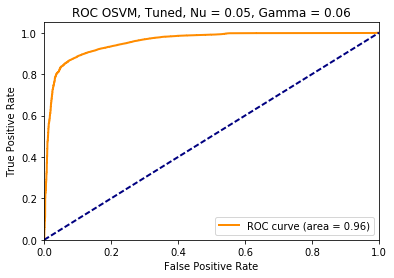

In [14]:
#Creats ROC curve
yTest = numpy.append(sigTestTarget, backTarget)
osvmScore = numpy.append(osvmArrs[1], osvmArrs[2])
fpr, tpr, _ = roc_curve(yTest, osvmScore)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2;
plt.plot(fpr, tpr, color='darkorange',
        lw = lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC OSVM, Tuned, Nu = %s, Gamma = %s' % (nuVal,gammaVal))
plt.legend(loc="lower right")
plt.show()